In [1]:
import numpy as np
import pandas as pd
import cudaq
from cudaq import spin
from typing import List, Tuple
import matplotlib.pyplot as plt
from math import sqrt
import math
import sys
import os
import torch
from tqdm import tqdm
import shutil
sys.path.append(os.path.abspath(".."))
from Utils.qaoaCUDAQ import po_normalize, ret_cov_to_QUBO, qubo_to_ising, process_ansatz_values, state_to_return, pauli_to_int, int_to_pauli,\
    basis_T_to_pauli, reversed_str_bases_to_init_state, kernel_qaoa_Preserved, kernel_qaoa_X, kernel_flipped, get_optimizer, find_budget,\
    all_state_to_return, get_init_states, write_df, clip_df

import seaborn as sns   
from copulas.multivariate import GaussianMultivariate
import joblib
import pickle

import time
cudaq.set_target("nvidia")
pd.set_option('display.width', 1000)
np.random.seed(50)
state = np.random.get_state()
# with open("rng_state.pkl", "wb") as f:
#     pickle.dump(state, f)
modes = ["X", "Preserving"]
report_col = ["Approximate_ratio", "MaxProb_ratio", "init_1_time", "init_2_time", "optim_time", "observe_time"]

# PIPELINE PARAMETERS
LOOP = 100
oversample_factor = 5
over_budget_bound = 1.0 # valid budget in [0, B * over_budget_bound]
min_P, max_P = 125, 250
hamiltonian_boost = 2000

# HYPER PARAMETERS
init_state_ratio = 0.1
TARGET_QUBIT = 14
N_ASSETS = 5
LAMB = 4 # Budget Penalty
Q = 0 # Volatility Weight

# num_init_bases = int(2**TARGET_QUBIT * init_state_ratio)
num_init_bases = 3

# TODO
- init_ratio of feasible
- store each epoch loss
- Avg approx
- plot x: qubits, y: approx_ratio

(972, 2)


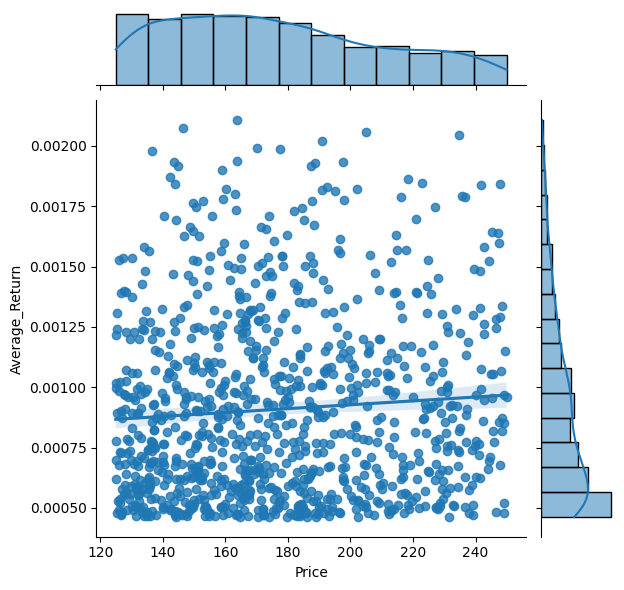

In [2]:
# with open("rng_state.pkl", "rb") as f:
#     state = pickle.load(f)
np.random.set_state(state)
GM_loaded = joblib.load('./models/gaussian_copula.pkl')
# samples = GM_loaded.sample(50)
samples = GM_loaded.sample(int(N_ASSETS * LOOP * oversample_factor))
samples = samples[(samples["Price"] > min_P) & (samples["Price"] < max_P)]
# print(samples["Average_Return"].min(), samples["Average_Return"].max())
# print(samples["Price"].min(), samples["Price"].max())
print(samples.shape)
assert samples.shape[0] > N_ASSETS * LOOP, "Please increase the oversample factor to get more samples ;-;"
sns.jointplot(data=samples, x='Price', y='Average_Return', kind='reg')
samples = samples.to_numpy()
plt.show()

In [3]:
dir_name = f"exp_Q{TARGET_QUBIT}_A{N_ASSETS}_L{LAMB}_q{Q}_B{num_init_bases}"
dir_name_Xbase = f"exp_Q{TARGET_QUBIT}_A{N_ASSETS}_L{LAMB}_q{Q}_B3"
dir_path = f"./experiments/{dir_name}"
dir_path_Xbase = f"./experiments/{dir_name_Xbase}"

In [4]:
state_init_loop = np.random.get_state()

In [5]:
assert False, "Please make sure of CLEAR_EX_RESULT and RESTORE_RUNTIME before running the code."

AssertionError: Please make sure of CLEAR_EX_RESULT and RESTORE_RUNTIME before running the code.

In [ ]:
CLEAR_EX_RESULT = True

restore_iter = 8
RESTORE_RUNTIME = False

if CLEAR_EX_RESULT:
    for curr_dir, dirs, files in os.walk(dir_path):
        for file in files:
            os.remove(os.path.join(curr_dir, file))

if RESTORE_RUNTIME:
    for mode in modes:
        df = pd.read_csv(f"./{dir_path}/{mode}.csv")
        df = clip_df(df, restore_iter)
        df.to_csv(f"{dir_path}/{mode}.csv", index=False)

    with open(f"{dir_path}/iter_states/{str(restore_iter).zfill(4)}.pkl", "rb") as f:
        state = pickle.load(f)
    np.random.set_state(state)

In [ ]:
assert False, "Please make sure of CLEAR_EX_RESULT and RESTORE_RUNTIME before running the code."

# Be careful!! CSV writing is in append mode

In [ ]:
os.makedirs(f"{dir_path}", exist_ok=True)
# os.makedirs(f"{dir_path}/Preserving", exist_ok=True)
os.makedirs(f"{dir_path}/expectations_X", exist_ok=True)
os.makedirs(f"{dir_path}/expectations_Preserving", exist_ok=True)
os.makedirs(f"{dir_path}/iter_states", exist_ok=True)


restore_iter = 0
if os.path.exists(f"{dir_path}/X.csv") and os.path.exists(f"{dir_path}/Preserving.csv"):
    for mode in modes:
        df = pd.read_csv(f"./{dir_path}/{mode}.csv")
        if restore_iter > 0:
            restore_iter = min(restore_iter, df.shape[0])
        else:
            restore_iter = df.shape[0]

    for mode in modes:
        df = pd.read_csv(f"./{dir_path}/{mode}.csv")
        df = clip_df(df, restore_iter)
        df.to_csv(f"{dir_path}/{mode}.csv", index=False)

    with open(f"{dir_path}/iter_states/{str(restore_iter).zfill(4)}.pkl", "rb") as f:
        state = pickle.load(f)
    np.random.set_state(state)

X_exist = False
if os.path.exists(f"{dir_path_Xbase}/result.csv"):
    shutil.copyfile(f"{dir_path_Xbase}/X.csv", f"{dir_path}/X.csv")
    shutil.copytree(f"{dir_path_Xbase}/expectations_X", f"{dir_path}/expectations_X", dirs_exist_ok=True)
    X_exist = True

# start_iter = restore_iter if RESTORE_RUNTIME else 0
start_iter = restore_iter
pbar = tqdm(range(start_iter, LOOP))
for i in pbar:
# for i in range(start_iter, LOOP):
    with open(f"{dir_path}/iter_states/{str(i).zfill(4)}.pkl", "wb") as f:
        pickle.dump(np.random.get_state(), f)

    pbar.set_description("global:init_1")
    st = time.time()

    P = samples[i * N_ASSETS:(i + 1) * N_ASSETS, 0]
    ret = samples[i * N_ASSETS:(i + 1) * N_ASSETS, 1]
    # print(P)
    # print(ret)
    
    # P = np.array([195.27, 183.26, 131.3])
    # ret = np.array([0.00107, 0.00083, 0.00071])
    cov = np.random.rand(N_ASSETS, N_ASSETS)
    cov += cov.T
    q = 0 # Volatility Weight
    B = find_budget(TARGET_QUBIT, P, min_P, max_P)
    # print(B)
    # break
    # B = 270
    P_bb, ret_bb, cov_bb, n_qubit, n_max, C = po_normalize(B, P, ret, cov)
    state_return, in_budget = all_state_to_return(B, C, ret, P, over_budget_bound)
    init_state = get_init_states(state_return, in_budget, num_init_bases, n_qubit)

    feasible_state_return = state_return * in_budget
    max_return = state_return[int(init_state[0], 2)]

    init_1_time = time.time() - st
    # print(f"initial: {init_1_time*1000:.2f} ms.")

    for mode in modes:
    # for mode in ["Preserving"]:
        if mode == "X" and X_exist:
            continue
        pbar.set_description(f"{mode}:init_2")
        st = time.time()
        lamb = LAMB if mode == "X" else 0 # Budget Penalty

        QU = -ret_cov_to_QUBO(ret_bb, cov_bb, P_bb, lamb, q)
        # print(QU.shape)
        H = qubo_to_ising(QU, lamb).canonicalize() * (1 if mode == "X" else hamiltonian_boost)

        QU_0 = -ret_cov_to_QUBO(ret_bb, cov_bb, P_bb, 0, q)
        H_0 = qubo_to_ising(QU_0, 0).canonicalize()
        # print(QU)
        # print(H)
        # print(QU_0)
        # print(H_0)

        # H_data, H_rows, H_cols = H.to_sparse_matrix(dimensions={i: 2 for i in range(TARGET_QUBIT)},invert_order=False)
        # # H_dense = H.to_matrix()
        # print(len(H_data), len(H_rows), len(H_cols))
        # print(H_data, H_rows, H_cols)

        idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use = process_ansatz_values(H)

        kernel_qaoa_use = kernel_qaoa_X if mode == "X" else kernel_qaoa_Preserved



        idx = 3
        layer_count = 5
        parameter_count = layer_count * 2
        optimizer, optimizer_name, FIND_GRAD = get_optimizer(idx)
        optimizer.max_iterations = 1000
        optimizer.initial_parameters = np.random.uniform(-np.pi / 8, np.pi / 8, parameter_count)

        if mode == "X":
            ansatz_fixed_param = (int(n_qubit), layer_count, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use)
            init_2_time = time.time() - st
            # print(f"init for {mode}: {init_2_time*1000:.2f} ms.")
        else:
            n_bases = len(init_state)
            # print("n_bases:", n_bases)
            T = np.zeros((n_bases, n_bases), dtype=np.float32)
            T[:-1, 1:] += np.eye(n_bases - 1, dtype=np.float32)
            T[1:, :-1] += np.eye(n_bases - 1, dtype=np.float32)
            T[0, -1] = T[-1, 0] = 1.0
            # print(T)
            mixer_s, mixer_c = basis_T_to_pauli(init_state, T, n_qubit)
            init_bases = reversed_str_bases_to_init_state(init_state, n_qubit)
            ansatz_fixed_param = (int(n_qubit), layer_count, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use, mixer_s, mixer_c, init_bases)
            init_2_time = time.time() - st
            # print(f"Init for {mode}: {init_2_time*1000:.2f} ms.")
        #     print(mixer_s)
        # print(cudaq.draw(kernel_qaoa_use, [10, 20], *ansatz_fixed_param[:1], 1, *ansatz_fixed_param[2:]))


        pbar.set_description(f"{mode}:optim")
        st = time.time()
        expectations = []
        # expectations2 = []
        # expectations3 = []
        def cost_func(parameters, cal_expectation=False):
            # return cudaq.observe(kernel_qaoa, H, n_qubit, layer_count, parameters, 0).expectation()
            if cal_expectation:
                # q_state = cudaq.get_state(kernel_qaoa_use, parameters, *ansatz_fixed_param)
                # q_state_r = cudaq.get_state(kernel_flipped, q_state, TARGET_QUBIT)
                # prob = np.abs(q_state_r)**2
                # exp_return = (prob * (feasible_state_return)).sum() / max_return
                # exp_return = (prob * (state_return)).sum() / max_return
                exp_return = cudaq.observe(kernel_qaoa_use, H_0, parameters, *ansatz_fixed_param).expectation()
                expectations.append(exp_return)
                # expectations2.append((prob * state_return).sum())


            return cudaq.observe(kernel_qaoa_use, H, parameters, *ansatz_fixed_param).expectation()

        def objective(parameters):
            expectation = cost_func(parameters, cal_expectation=True)
            # expectations3.append(expectation)
            return expectation

        def objective_grad_cuda(parameters):
            expectation = cost_func(parameters, cal_expectation=True)
            # expectations3.append(expectation)

            gradient = cudaq.gradients.ForwardDifference().compute(parameters, cost_func, expectation)

            return expectation, gradient

        objective_func = objective_grad_cuda if FIND_GRAD else objective

        optimal_expectation, optimal_parameters = optimizer.optimize(
            dimensions=parameter_count, function=objective_func)
        np.save(f"{dir_path}/expectations_{mode}/expectations_{i}.npy", np.array(expectations))
        optim_time = time.time() - st
        # print(f"Optimization for {mode}: {optim_time*1000:.2f} ms.")
        
        pbar.set_description(f"{mode}:observe")
        st = time.time()
        result = cudaq.get_state(kernel_qaoa_use, optimal_parameters, *ansatz_fixed_param)
        idx_r_best = np.argmax(np.abs(result))
        idx_best = bin(idx_r_best)[2:].zfill(n_qubit)[::-1]

        result_r = cudaq.get_state(kernel_flipped, result, TARGET_QUBIT)
        prob = np.abs(result_r)**2

        approx_ratio = (prob * (feasible_state_return)).sum() / max_return
        maxprob_ratio = state_return[int(idx_best, 2)] / max_return if in_budget[int(idx_best, 2)] else 0.0

        observe_time = time.time() - st

        write_df(f"{dir_path}/{mode}.csv", report_col,
                    approx_ratio, maxprob_ratio, init_1_time, init_2_time, optim_time, observe_time)
        
        del expectations, objective_grad_cuda, objective, objective_func, cost_func, optimizer, optimal_parameters, result, result_r, prob
        del H, QU, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use
        del ansatz_fixed_param
        if mode == "Preserving":
            del mixer_s, mixer_c, init_bases, T

    del P, ret, cov, P_bb, ret_bb, cov_bb, C, n_qubit, n_max
    del state_return, in_budget, init_state
        

    #     break
    # break
        # print(f"Observation: {observe_time*1000:.2f} ms.")

        # print(idx_best, init_state[0])
        # print(state_return[int(idx_best, 2)], in_budget[int(idx_best, 2)], state_return[int(init_state[0], 2)], in_budget[int(init_state[0], 2

        # approx_ratio = state_return[int(idx_best, 2)] / state_return[int(init_state[0], 2)] if in_budget[int(idx_best, 2)] else 0.0
        # write_df(f"{dir_path}/{mode}.csv", 
        #             approx_ratio, init_1_time, init_2_time, optim_time, observe_time)
    

# dir_path = "./experiments/exp_Q6_A5_L4_q0_B25"
df_X = pd.read_csv(f"{dir_path}/X.csv")
df_P = pd.read_csv(f"{dir_path}/Preserving.csv")

approx_X = df_X["Approximate_ratio"].mean()
approx_P = df_P["Approximate_ratio"].mean()
print(f"Approximate ratio for X: {approx_X:.4f}, Preserving: {approx_P:.4f}")

maxprob_X = df_X["MaxProb_ratio"].mean()
maxprob_P = df_P["MaxProb_ratio"].mean()
print(f"MaxProb ratio for X: {maxprob_X:.4f}, Preserving: {maxprob_P:.4f}")

init_1_time_X = df_X["init_1_time"].mean()
init_2_time_X = df_X["init_2_time"].mean()
optim_time_X = df_X["optim_time"].mean()
observe_time_X = df_X["observe_time"].mean()

init_1_time_P = df_P["init_1_time"].mean()
init_2_time_P = df_P["init_2_time"].mean()
optim_time_P = df_P["optim_time"].mean()
observe_time_P = df_P["observe_time"].mean()

print(f"Init 1 time for X: {init_1_time_X*1000:.2f} ms, Preserving: {init_1_time_P*1000:.2f} ms")
print(f"Init 2 time for X: {init_2_time_X*1000:.2f} ms, Preserving: {init_2_time_P*1000:.2f} ms")
print(f"Optim time for X: {optim_time_X*1000:.2f} ms, Preserving: {optim_time_P*1000:.2f} ms")
print(f"Observe time for X: {observe_time_X*1000:.2f} ms, Preserving: {observe_time_P*1000:.2f} ms")

col_result = ["Mode"] + report_col
df_result = pd.DataFrame(columns=col_result)
df_result.loc[0] = ["X", approx_X, maxprob_X, init_1_time_X, init_2_time_X, optim_time_X, observe_time_X]
df_result.loc[1] = ["Preserving", approx_P, maxprob_P, init_1_time_P, init_2_time_P, optim_time_P, observe_time_P]
df_result.to_csv(f"{dir_path}/result.csv", index=False)


Preserving:observe: 100%|██████████| 30/30 [02:18<00:00,  4.60s/it]

Approximate ratio for X: 0.5130, Preserving: 0.9729
MaxProb ratio for X: 0.3874, Preserving: 1.0000
Init 1 time for X: 0.18 ms, Preserving: 0.18 ms
Init 2 time for X: 0.47 ms, Preserving: 0.64 ms
Optim time for X: 3207.39 ms, Preserving: 1148.06 ms
Observe time for X: 1.49 ms, Preserving: 2.23 ms


In [ ]:
df_X = pd.read_csv(f"{dir_path}/X.csv")
df_P = pd.read_csv(f"{dir_path}/Preserving.csv")

approx_X = df_X["Approximate_ratio"].mean()
approx_P = df_P["Approximate_ratio"].mean()
print(f"Approximate ratio for X: {approx_X:.4f}, Preserving: {approx_P:.4f}")

maxprob_X = df_X["MaxProb_ratio"].mean()
maxprob_P = df_P["MaxProb_ratio"].mean()
print(f"MaxProb ratio for X: {maxprob_X:.4f}, Preserving: {maxprob_P:.4f}")

init_1_time_X = df_X["init_1_time"].mean()
init_2_time_X = df_X["init_2_time"].mean()
optim_time_X = df_X["optim_time"].mean()
observe_time_X = df_X["observe_time"].mean()

init_1_time_P = df_P["init_1_time"].mean()
init_2_time_P = df_P["init_2_time"].mean()
optim_time_P = df_P["optim_time"].mean()
observe_time_P = df_P["observe_time"].mean()

print(f"Init 1 time for X: {init_1_time_X*1000:.2f} ms, Preserving: {init_1_time_P*1000:.2f} ms")
print(f"Init 2 time for X: {init_2_time_X*1000:.2f} ms, Preserving: {init_2_time_P*1000:.2f} ms")
print(f"Optim time for X: {optim_time_X*1000:.2f} ms, Preserving: {optim_time_P*1000:.2f} ms")
print(f"Observe time for X: {observe_time_X*1000:.2f} ms, Preserving: {observe_time_P*1000:.2f} ms")

col_result = ["Mode"] + report_col
df_result = pd.DataFrame(columns=col_result)
df_result.loc[0] = ["X", approx_X, maxprob_X, init_1_time_X, init_2_time_X, optim_time_X, observe_time_X]
df_result.loc[1] = ["Preserving", approx_P, maxprob_P, init_1_time_P, init_2_time_P, optim_time_P, observe_time_P]
df_result.to_csv(f"{dir_path}/result.csv", index=False)

Approximate ratio for X: 0.1550, Preserving: 0.9452
MaxProb ratio for X: 0.2117, Preserving: 1.0000
Init 1 time for X: 0.18 ms, Preserving: 0.18 ms
Init 2 time for X: 0.47 ms, Preserving: 0.63 ms
Optim time for X: 23.54 ms, Preserving: 1386.93 ms
Observe time for X: 1.38 ms, Preserving: 1.87 ms


In [ ]:
# plt.plot(expectations)
# plt.show()
# plt.plot(expectations2)
# plt.show()
# plt.plot(expectations3)
# plt.show()

In [ ]:
assert False

AssertionError: 

In [ ]:
ch_tr = True
for TARGET_QUBIT in [5, 8]:
    for N_ASSETS in range(3, 6):
        for num_init_bases in [12]:

            if TARGET_QUBIT < N_ASSETS:
                continue

            print(f"Target Qubit: {TARGET_QUBIT}, N Assets: {N_ASSETS}, Num Init Bases: {num_init_bases}")
            # continue
            dir_name = f"exp_Q{TARGET_QUBIT}_A{N_ASSETS}_L{LAMB}_q{Q}_B{num_init_bases}"
            dir_name_Xbase = f"exp_Q{TARGET_QUBIT}_A{N_ASSETS}_L{LAMB}_q{Q}_B3"
            dir_path = f"./experiments/{dir_name}"
            dir_path_Xbase = f"./experiments/{dir_name_Xbase}"
            if os.path.exists(f"{dir_path}/result.csv"):
                print("Completed")
                continue

            os.makedirs(f"{dir_path}", exist_ok=True)
            # os.makedirs(f"{dir_path}/Preserving", exist_ok=True)
            os.makedirs(f"{dir_path}/expectations_X", exist_ok=True)
            os.makedirs(f"{dir_path}/expectations_Preserving", exist_ok=True)
            # os.makedirs(f"{dir_path}/iter_states", exist_ok=True)

            # continue

            np.random.set_state(state_init_loop)
            restore_iter = 0
            if os.path.exists(f"{dir_path}/X.csv") and os.path.exists(f"{dir_path}/Preserving.csv"):
                for mode in modes:
                    df = pd.read_csv(f"./{dir_path}/{mode}.csv")
                    if restore_iter > 0:
                        restore_iter = min(restore_iter, df.shape[0])
                    else:
                        restore_iter = df.shape[0]

                for mode in modes:
                    df = pd.read_csv(f"./{dir_path}/{mode}.csv")
                    df = clip_df(df, restore_iter)
                    df.to_csv(f"{dir_path}/{mode}.csv", index=False)

                for i in range(restore_iter):
                    np.random.rand(N_ASSETS, N_ASSETS)
                    np.random.uniform(-np.pi / 8, np.pi / 8, LAYER * 4)
            else:
                for curr_dir, dirs, files in os.walk(dir_path):
                    for file in files:
                        os.remove(os.path.join(curr_dir, file))

            X_exist = False
            if os.path.exists(f"{dir_path_Xbase}/result.csv"):
                shutil.copyfile(f"{dir_path_Xbase}/X.csv", f"{dir_path}/X.csv")
                shutil.copytree(f"{dir_path_Xbase}/expectations_X", f"{dir_path}/expectations_X", dirs_exist_ok=True)
                X_exist = True
                
            pbar = tqdm(range(restore_iter, LOOP))
            for i in pbar:
                # if i == 1 and ch_tr:
                #     # tr = tracker.SummaryTracker()
                #     print("Start Tracking GB")
                #     ch_tr = False

                pbar.set_description("global:init_1")
                st = time.time()

                P = samples[i * N_ASSETS:(i + 1) * N_ASSETS, 0]
                ret = samples[i * N_ASSETS:(i + 1) * N_ASSETS, 1]
                # print(P)
                # print(ret)
                
                # P = np.array([195.27, 183.26, 131.3])
                # ret = np.array([0.00107, 0.00083, 0.00071])
                cov = np.random.rand(N_ASSETS, N_ASSETS)
                cov += cov.T
                q = 0 # Volatility Weight
                B = find_budget(TARGET_QUBIT, P, min_P, max_P)
                # print(B)
                # break
                # B = 270
                P_bb, ret_bb, cov_bb, n_qubit, n_max, C = po_normalize(B, P, ret, cov)
                state_return, in_budget = all_state_to_return(B, C, ret, P, over_budget_bound)
                init_state = get_init_states(state_return, in_budget, num_init_bases, n_qubit)

                feasible_state_return = state_return * in_budget
                max_return = state_return[int(init_state[0], 2)]

                init_1_time = time.time() - st
                # print(f"initial: {init_1_time*1000:.2f} ms.")

                for mode in modes:
                    if mode == "X" and X_exist:
                        continue
                    pbar.set_description(f"{mode}:init_2")
                    st = time.time()
                    lamb = LAMB if mode == "X" else 0 # Budget Penalty

                    QU = -ret_cov_to_QUBO(ret_bb, cov_bb, P_bb, lamb, q)
                    H = qubo_to_ising(QU, lamb).canonicalize() * (1 if mode == "X" else hamiltonian_boost)
                    QU_0 = -ret_cov_to_QUBO(ret_bb, cov_bb, P_bb, 0, q)
                    H_0 = qubo_to_ising(QU_0, 0).canonicalize()
                    idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use = process_ansatz_values(H)

                    kernel_qaoa_use = kernel_qaoa_X if mode == "X" else kernel_qaoa_Preserved

                    idx = 3
                    layer_count = 5
                    parameter_count = layer_count * 2
                    optimizer, optimizer_name, FIND_GRAD = get_optimizer(idx)
                    optimizer.max_iterations = 1000
                    optimizer.initial_parameters = np.random.uniform(-np.pi / 8, np.pi / 8, parameter_count)

                    if mode == "X":
                        ansatz_fixed_param = (int(n_qubit), layer_count, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use)
                        init_2_time = time.time() - st
                        # print(f"init for {mode}: {init_2_time*1000:.2f} ms.")
                    else:
                        n_bases = len(init_state)
                        # print("n_bases:", n_bases)
                        T = np.zeros((n_bases, n_bases), dtype=np.float32)
                        T[:-1, 1:] += np.eye(n_bases - 1, dtype=np.float32)
                        T[1:, :-1] += np.eye(n_bases - 1, dtype=np.float32)
                        T[0, -1] = T[-1, 0] = 1.0
                        # print(T)
                        mixer_s, mixer_c = basis_T_to_pauli(init_state, T, n_qubit)
                        init_bases = reversed_str_bases_to_init_state(init_state, n_qubit)
                        ansatz_fixed_param = (int(n_qubit), layer_count, idx_1_use, coeff_1_use, idx_2_a_use, idx_2_b_use, coeff_2_use, mixer_s, mixer_c, init_bases)
                        init_2_time = time.time() - st
                        # print(f"Init for {mode}: {init_2_time*1000:.2f} ms.")
                    # print(cudaq.draw(kernel_qaoa_use, [0.5]*4, *ansatz_fixed_param[:1], 1, *ansatz_fixed_param[2:]))

                    pbar.set_description(f"{mode}:optim")
                    st = time.time()
                    expectations = []
                    # expectations2 = []
                    # expectations3 = []
                    def cost_func(parameters, cal_expectation=False):
                        # return cudaq.observe(kernel_qaoa, H, n_qubit, layer_count, parameters, 0).expectation()
                        if cal_expectation:
                            # q_state = cudaq.get_state(kernel_qaoa_use, parameters, *ansatz_fixed_param)
                            # q_state_r = cudaq.get_state(kernel_flipped, q_state, TARGET_QUBIT)
                            # prob = np.abs(q_state_r)**2
                            # exp_return = (prob * (feasible_state_return)).sum() / max_return
                            # exp_return = (prob * (state_return)).sum() / max_return
                            exp_return = cudaq.observe(kernel_qaoa_use, H_0, parameters, *ansatz_fixed_param).expectation()
                            expectations.append(exp_return)
                            # expectations2.append((prob * state_return).sum())
                        return cudaq.observe(kernel_qaoa_use, H, parameters, *ansatz_fixed_param).expectation()
                    
                        #     exp_return = cudaq.observe(kernel_qaoa_use, H_0, parameters, *ansatz_fixed_param, execution=cudaq.parallel.thread).expectation()
                        #     expectations.append(exp_return)
                        # return cudaq.observe(kernel_qaoa_use, H, parameters, *ansatz_fixed_param, execution=cudaq.parallel.thread).expectation()

                    def objective(parameters):
                        expectation = cost_func(parameters, cal_expectation=True)
                        # expectations3.append(expectation)
                        return expectation

                    def objective_grad_cuda(parameters):
                        expectation = cost_func(parameters, cal_expectation=True)
                        # expectations3.append(expectation)

                        gradient = cudaq.gradients.ForwardDifference().compute(parameters, cost_func, expectation)

                        return expectation, gradient

                    objective_func = objective_grad_cuda if FIND_GRAD else objective

                    optimal_expectation, optimal_parameters = optimizer.optimize(
                        dimensions=parameter_count, function=objective_func)
                    np.save(f"{dir_path}/expectations_{mode}/expectations_{i}.npy", np.array(expectations))
                    optim_time = time.time() - st
                    # print(f"Optimization for {mode}: {optim_time*1000:.2f} ms.")
                    
                    pbar.set_description(f"{mode}:observe")
                    st = time.time()
                    result = cudaq.get_state(kernel_qaoa_use, optimal_parameters, *ansatz_fixed_param)
                    idx_r_best = np.argmax(np.abs(result))
                    idx_best = bin(idx_r_best)[2:].zfill(n_qubit)[::-1]

                    result_r = cudaq.get_state(kernel_flipped, result, TARGET_QUBIT)
                    prob = np.abs(result_r)**2

                    approx_ratio = (prob * (feasible_state_return)).sum() / max_return
                    maxprob_ratio = state_return[int(idx_best, 2)] / max_return if in_budget[int(idx_best, 2)] else 0.0

                    observe_time = time.time() - st

                    write_df(f"{dir_path}/{mode}.csv", report_col,
                                approx_ratio, maxprob_ratio, init_1_time, init_2_time, optim_time, observe_time)
                    # gc.collect()

            df_X = pd.read_csv(f"{dir_path}/X.csv")
            df_P = pd.read_csv(f"{dir_path}/Preserving.csv")

            approx_X = df_X["Approximate_ratio"].mean()
            approx_P = df_P["Approximate_ratio"].mean()
            print(f"Approximate ratio for X: {approx_X:.4f}, Preserving: {approx_P:.4f}")

            maxprob_X = df_X["MaxProb_ratio"].mean()
            maxprob_P = df_P["MaxProb_ratio"].mean()
            print(f"MaxProb ratio for X: {maxprob_X:.4f}, Preserving: {maxprob_P:.4f}")

            init_1_time_X = df_X["init_1_time"].mean()
            init_2_time_X = df_X["init_2_time"].mean()
            optim_time_X = df_X["optim_time"].mean()
            observe_time_X = df_X["observe_time"].mean()

            init_1_time_P = df_P["init_1_time"].mean()
            init_2_time_P = df_P["init_2_time"].mean()
            optim_time_P = df_P["optim_time"].mean()
            observe_time_P = df_P["observe_time"].mean()

            print(f"Init 1 time for X: {init_1_time_X*1000:.2f} ms, Preserving: {init_1_time_P*1000:.2f} ms")
            print(f"Init 2 time for X: {init_2_time_X*1000:.2f} ms, Preserving: {init_2_time_P*1000:.2f} ms")
            print(f"Optim time for X: {optim_time_X*1000:.2f} ms, Preserving: {optim_time_P*1000:.2f} ms")
            print(f"Observe time for X: {observe_time_X*1000:.2f} ms, Preserving: {observe_time_P*1000:.2f} ms")

            col_result = ["Mode"] + report_col
            df_result = pd.DataFrame(columns=col_result)
            df_result.loc[0] = ["X", approx_X, maxprob_X, init_1_time_X, init_2_time_X, optim_time_X, observe_time_X]
            df_result.loc[1] = ["Preserving", approx_P, maxprob_P, init_1_time_P, init_2_time_P, optim_time_P, observe_time_P]
            df_result.to_csv(f"{dir_path}/result.csv", index=False)

Target Qubit: 5, N Assets: 3, Num Init Bases: 12


Preserving:observe: 100%|██████████| 100/100 [12:14<00:00,  7.34s/it]


Approximate ratio for X: 0.5130, Preserving: 0.8873
MaxProb ratio for X: 0.3874, Preserving: 0.9786
Init 1 time for X: 0.18 ms, Preserving: 0.18 ms
Init 2 time for X: 0.44 ms, Preserving: 3.87 ms
Optim time for X: 3011.07 ms, Preserving: 7331.36 ms
Observe time for X: 1.48 ms, Preserving: 4.18 ms
Target Qubit: 5, N Assets: 4, Num Init Bases: 12


Preserving:observe: 100%|██████████| 100/100 [10:56<00:00,  6.56s/it]


Approximate ratio for X: 0.5090, Preserving: 0.9249
MaxProb ratio for X: 0.3951, Preserving: 0.9917
Init 1 time for X: 0.18 ms, Preserving: 0.17 ms
Init 2 time for X: 0.41 ms, Preserving: 2.29 ms
Optim time for X: 3510.83 ms, Preserving: 6552.40 ms
Observe time for X: 1.45 ms, Preserving: 3.72 ms
Target Qubit: 5, N Assets: 5, Num Init Bases: 12


Preserving:observe: 100%|██████████| 100/100 [09:32<00:00,  5.72s/it]


Approximate ratio for X: 0.5695, Preserving: 0.9296
MaxProb ratio for X: 0.4113, Preserving: 0.9862
Init 1 time for X: 0.18 ms, Preserving: 0.17 ms
Init 2 time for X: 0.41 ms, Preserving: 2.00 ms
Optim time for X: 4084.43 ms, Preserving: 5714.95 ms
Observe time for X: 1.15 ms, Preserving: 3.51 ms
Target Qubit: 8, N Assets: 3, Num Init Bases: 12


Preserving:observe: 100%|██████████| 100/100 [40:52<00:00, 24.53s/it] 


Approximate ratio for X: 0.4404, Preserving: 0.8579
MaxProb ratio for X: 0.3010, Preserving: 0.9842
Init 1 time for X: 0.44 ms, Preserving: 0.42 ms
Init 2 time for X: 1.05 ms, Preserving: 55.33 ms
Optim time for X: 9404.53 ms, Preserving: 24428.71 ms
Observe time for X: 3.12 ms, Preserving: 40.01 ms
Target Qubit: 8, N Assets: 4, Num Init Bases: 12


Preserving:observe: 100%|██████████| 100/100 [51:31<00:00, 30.92s/it]


Approximate ratio for X: 0.4165, Preserving: 0.7951
MaxProb ratio for X: 0.2261, Preserving: 0.9773
Init 1 time for X: 0.43 ms, Preserving: 0.42 ms
Init 2 time for X: 1.06 ms, Preserving: 57.51 ms
Optim time for X: 10737.28 ms, Preserving: 30818.60 ms
Observe time for X: 3.17 ms, Preserving: 40.63 ms
Target Qubit: 8, N Assets: 5, Num Init Bases: 12


Preserving:observe: 100%|██████████| 100/100 [59:21<00:00, 35.61s/it] 

Approximate ratio for X: 0.4113, Preserving: 0.7770
MaxProb ratio for X: 0.2013, Preserving: 0.9655
Init 1 time for X: 0.42 ms, Preserving: 0.42 ms
Init 2 time for X: 1.03 ms, Preserving: 58.98 ms
Optim time for X: 13628.37 ms, Preserving: 35508.29 ms
Observe time for X: 3.00 ms, Preserving: 41.35 ms


In [ ]:
print(len(expectations))

111


In [ ]:
tr.print_diff()

In [ ]:
# print all global variables
for name, value in globals().items():
    print(f"{name}: {value}")

In [ ]:
from pympler import summary
from pympler import muppy
all_objects = muppy.get_objects()
len(all_objects) 

In [ ]:
sum1 = summary.summarize(all_objects)
summary.print_(sum1, limit=100)

In [ ]:
my_types = muppy.filter(all_objects, Type=str)
print(len(my_types))
for i in my_types[:10]:
    print(i)

In [ ]:
assert False

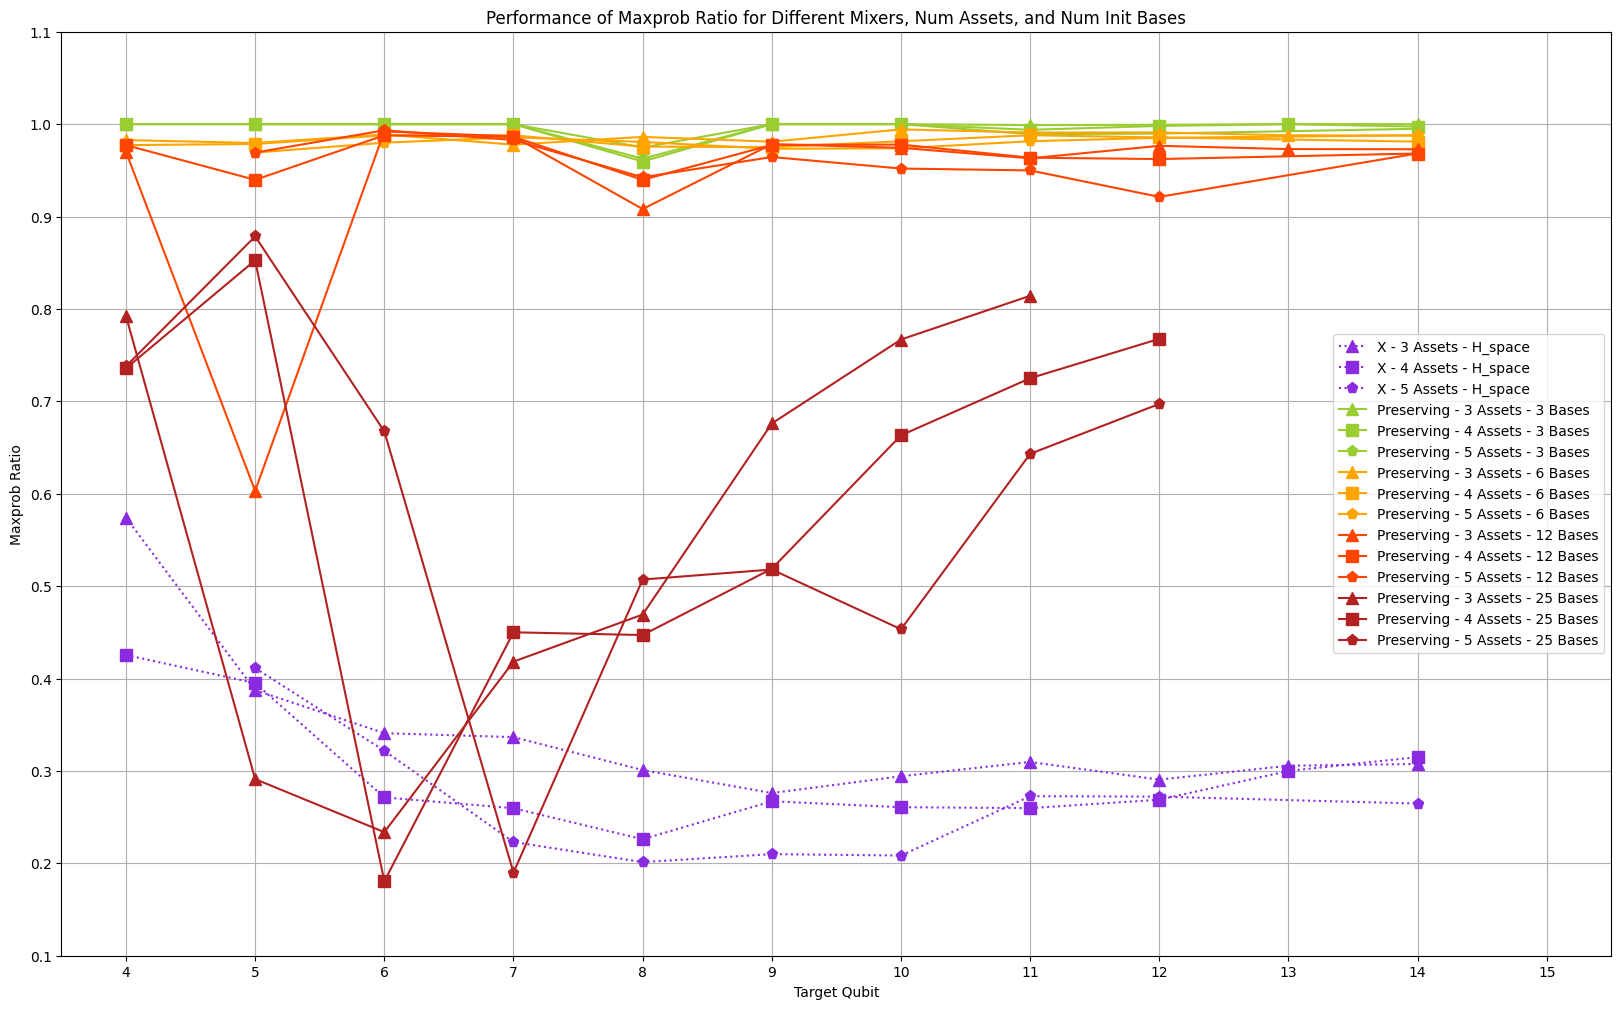

In [ ]:
marker_map = {3: "^", 4: "s", 5: "p"}
color_map = {(3, 'Preserving'): "yellowgreen",
                (6, 'Preserving'): "orange",
                (12, 'Preserving'): "orangered",
                (25, 'Preserving'): "firebrick",
                ("H_space", "X"): "blueviolet"}
line_map = {"X": ":", "Preserving": "-"}
plot_mode = ["Approximate_ratio", "MaxProb_ratio"][1]
plt.figure(figsize=(20, 12))
for mode in modes:
    for num_init_bases in (["H_space"] if mode == "X" else [3, 6, 12, 25]):
        for N_ASSETS in range(3, 6):
            mode_results = []
            range_qubit = []
            for TARGET_QUBIT in range(4, 20):
                dir_name = f"exp_Q{TARGET_QUBIT}_A{N_ASSETS}_L{LAMB}_q{Q}_B{3 if mode == 'X' else num_init_bases}"
                dir_path = f"./experiments/{dir_name}"
                if not os.path.exists(f"{dir_path}/result.csv"):
                    continue
                df = pd.read_csv(f"{dir_path}/result.csv")
                mode_result = df[df["Mode"] == mode][plot_mode].values[0]
                mode_results.append(mode_result)
                range_qubit.append(TARGET_QUBIT)
            plt.plot(range_qubit, mode_results, marker=marker_map[N_ASSETS], color=color_map[(num_init_bases, mode)], linestyle=line_map[mode], label=f"{mode} - {N_ASSETS} Assets - {num_init_bases}{'' if mode == 'X' else ' Bases'}", markersize=8)
plt.xlabel("Target Qubit")
plt.ylabel(plot_mode.replace("_", " ").title())
plt.title(f"Performance of {plot_mode.replace('_', ' ').title()} for Different Mixers, Num Assets, and Num Init Bases")
plt.xlim(3.5, 15.5)
plt.legend()
plt.grid()
ax = plt.gca()
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_xticks(np.arange(int(np.ceil(xmin)), int(np.floor(xmax)) + 1))
ax.set_yticks(np.arange(np.floor(ymin*10)/10, np.ceil(ymax*10)/10 + 0.1, 0.1))
plt.show()

In [ ]:
read_report = pd.read_csv(f"./experiments/exp_Q6_A3_L1.5_q0_B6/result.csv")
print(read_report)

In [ ]:
a = torch.arange(10)
aa = torch.tensor(a, device='cuda')

ab = torch.abs(aa)
am = torch.argmax(ab)

In [ ]:
a = np.zeros((1<<25), dtype=np.complex64)

In [ ]:
# for i in result.getTensors():
#     print(i.)

In [ ]:
st = time.time()
# result = cudaq.get_state(kernel_qaoa_use, optimal_parameters, *ansatz_fixed_param)
torch.argmax(torch.abs(torch.tensor(np.array(result), device='cuda')))
# am = np.argmax(np.abs(a))
# am = np.argmax(np.abs(result))

ed = time.time() - st
print(f"Observation: {ed*1000:.2f} ms.")

In [ ]:
# import numpy as np
# import torch as th
# c=np.random.rand(10000000).astype(np.float32) # cpu version
# g=th.tensor(c).to(device='cuda:0')             # gpu version
# %timeit -n 10 np.median(c,axis=0)    
# %timeit -n 10 np.sort(c,axis=0)[1]      
# %timeit -n 10 th.median(g,dim=0).values 
# %timeit -n 10 th.sort(g,dim=0).values[1]

59.8 ms ± 111 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)

587 ms ± 242 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)

246 μs ± 591 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)

41.9 ms ± 102 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

In [12]:
with open(f"./experiments/exp_Q7_A3_L4_q0_B12/iter_states/0000.pkl", "rb") as f:
    state = pickle.load(f)
np.random.set_state(state)
print(np.random.rand(5))

[0.96185316 0.05269905 0.49441923 0.04271331 0.75517684]
